# Лабораторная работа 1
### Выполнила: Иванова Анастасия Денисовна

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

my_seed = 243
random.seed(my_seed)
np.random.seed(my_seed)

In [2]:
# загружаем датасет train & test
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

### EDA (исследовательский анализ данных)

Анализ df_train

Для удобства отсортируем по id

In [21]:
df_train.sort_values(by="id")
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,theta1,theta2,price
0,17044,0.28,Ideal,F,VVS2,61.6,55.0,4.22,4.26,2.61,5,5,612
1,30625,0.28,Ideal,I,VS1,62.5,54.0,4.18,4.23,2.63,5,6,448
2,17043,0.28,'Very Good',F,IF,62.2,55.0,4.23,4.26,NaN,5,7,612
3,37947,0.28,'Very Good',E,VS2,63.0,59.0,4.11,4.15,2.60,5,8,487
4,30626,0.28,Ideal,I,VS1,62.4,54.0,4.18,4.19,2.61,5,9,448


Интерпретация данных:

id: Идентификационный номер алмаза.

carat: Вес алмаза, измеряемый в каратах. 1 карат = 200 миллиграмм. 

cut: Качество огранки алмаза. 

color: Цвет алмаза.

clarity: Чистота алмаза.

depth: Глубина алмаза.

table: Ширина или площадь вершины алмаза.

x, y, z: Физические размеры алмаза по трем осям.

theta1, theta2: Углы, связанные с огранкой. 

Смотрим на статистические характеристики датафрейма

In [4]:
df_train.describe()


,id,carat,depth,table,x,y,z,theta1,theta2,price
count,40453.000000,40453.00000,40396.000000,40453.000000,40405.000000,40393.000000,40411.000000,40453.000000,40453.000000,40453.000000
mean,26946.030529,0.77475,61.755897,57.438563,5.704927,18.773722,3.523399,19.071738,19.036190,3736.247003
std,15761.901131,0.41728,1.425065,2.225439,1.033411,350.627591,0.656404,8.527417,8.570144,3615.804536
min,3.000000,0.28000,43.000000,43.000000,0.000000,0.000000,0.000000,5.000000,5.000000,334.000000
25%,13160.000000,0.40000,61.100000,56.000000,4.740000,4.750000,2.930000,11.000000,11.000000,979.000000
50%,27038.000000,0.70000,61.800000,57.000000,5.700000,5.710000,3.520000,19.000000,19.000000,2401.000000
75%,40768.000000,1.03000,62.500000,59.000000,6.510000,6.510000,4.020000,27.000000,27.000000,5154.000000
max,53939.000000,2.02000,79.000000,79.000000,8.800000,9428.922353,31.800000,33.000000,33.000000,18803.000000


<Figure size 1000x600 with 0 Axes>

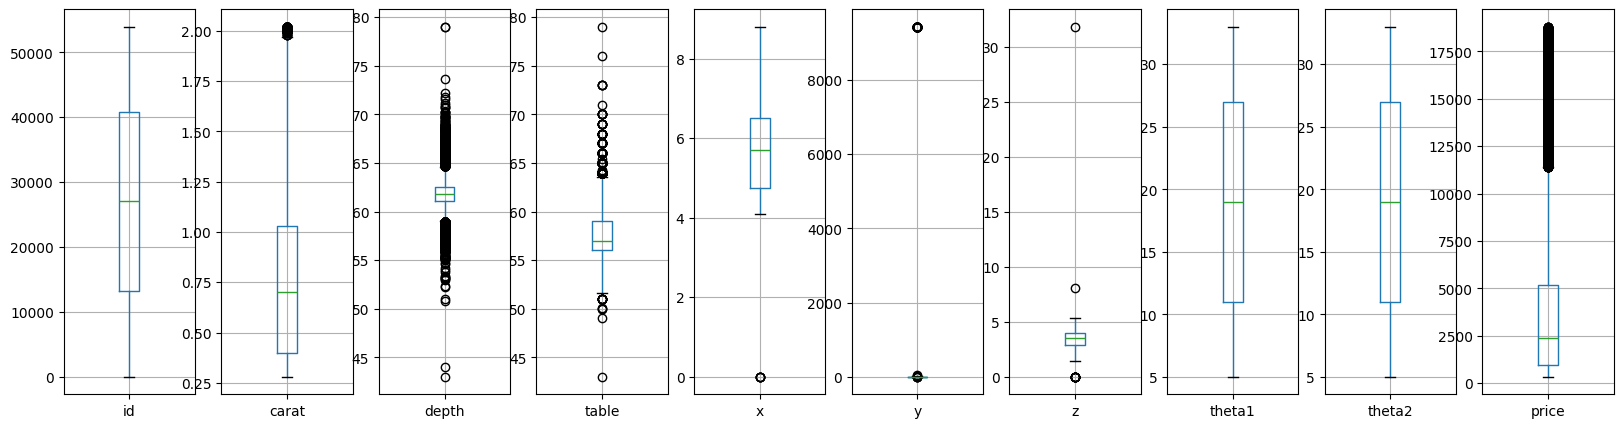

In [5]:
columns = ['id', 'carat', 'depth', 'table', 'x', 'y', 'z', 'theta1', 'theta2', 'price']

plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
for i, col in enumerate(columns):
    df_train[[col]].boxplot(ax=axes[i])
plt.show()

По боксплотам делаем вывод, что выбросы, которые могут помешать обучению модели, есть у x, y, z. 

Пока не ясно, понадобится ли удалять выбросы у глубины и ширины вершины алмаза, решим это в ходе дальнейших экспериментов.

Посмотрим на корреляции между признаками

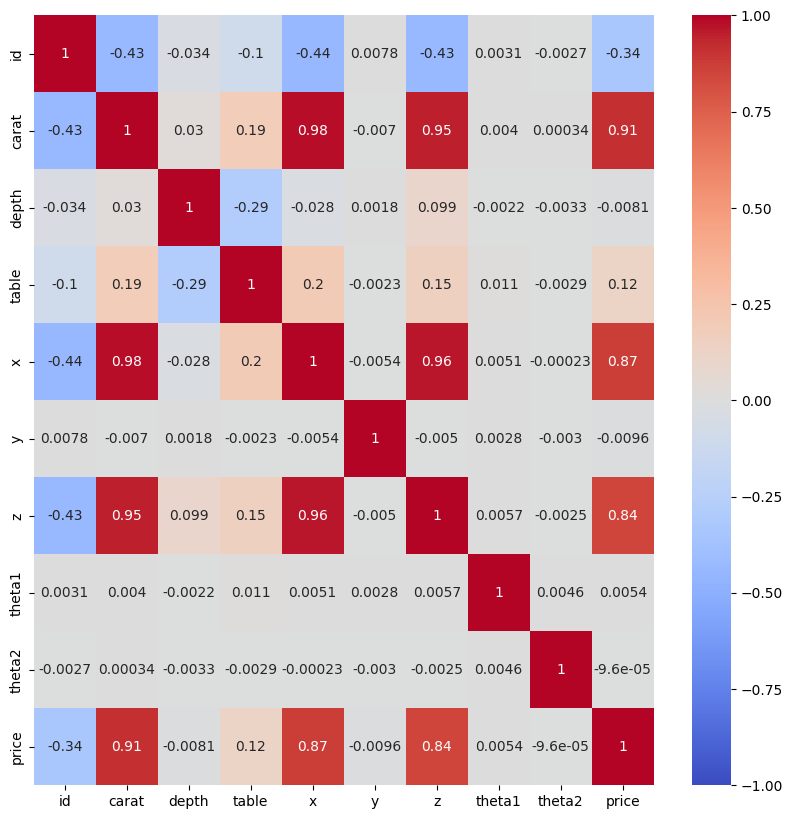

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_train[["id", "carat", "depth", "table", "x", "y", "z", "theta1", "theta2", "price"]].corr()

plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

У id есть небольшая зависимость (но все-таки зависимость) с каратом, x, z и ценой, поэтому оставляем его в выборке.

У глубины есть небольшая зависимость с площадью вершины алмаза, поэтому тоже оставляем.

У игрека на удивление корреляция с другими признаками близка к нулю, но т.к. он составляет физический размер алмаза, удалять мы его не будем.

x и z однозначно попадают в выборку для обучения не только из-за их реального значения для алмаза (размер), но и благодаря достаточно высокой линейной зависимости с ценой.

theta1. theta2 не имеют линейных зависимостей с другими признаками и не несут большого смысла для алмаза (хотя бы по сравнению с игреком), поэтому не будем учитывать их в обучении модели.

In [7]:
for column in ['theta1', 'theta2']:
    del df_train[column]
    del df_test[column]

Посмотрим, есть ли у нас пропуски в данных

In [8]:
df_train.isnull().sum()

id          0
carat       0
cut         0
color       0
clarity    64
depth      57
table       0
x          48
y          60
z          42
price       0
dtype: int64

Пропуски есть в чистоте, глубине, x, y, z. Пропуск в чистоте можно заполнить модой, т.к. это категориальный признак. В остальных можно использовать среднее, медиану, моду. Либо вообще можно пропуски удалить, т.к. их мало.

Хотелось бы как-то использовать физические размеры алмаза по трем осям вместе, поэтому взглянем на их произведение (на объем).

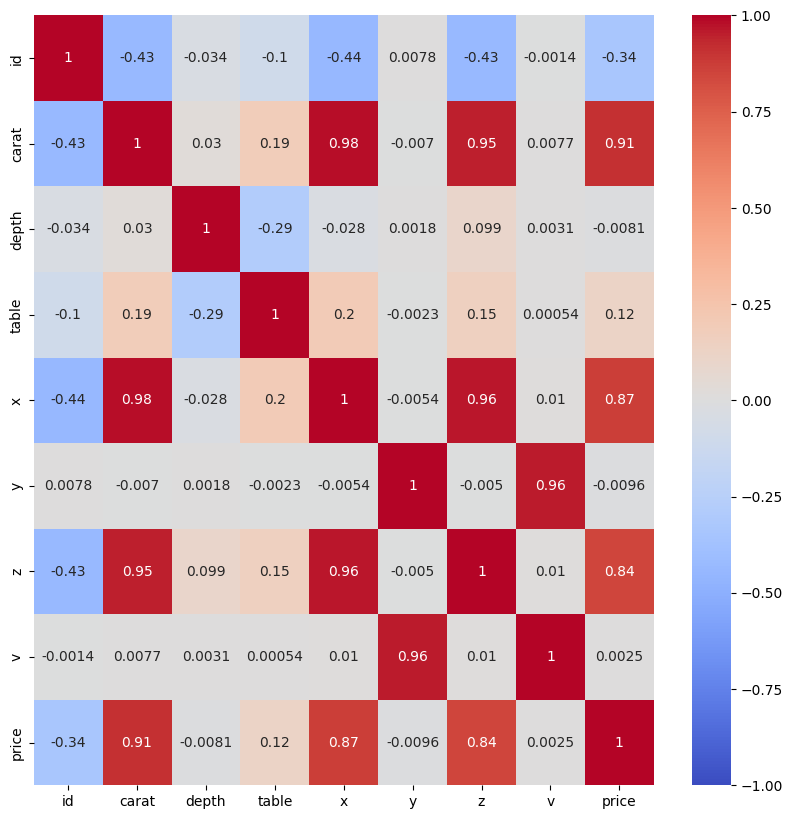

In [9]:
df_train["v"] = df_train["x"] * df_train["y"] * df_train['z']

correlation_matrix = df_train[["id", "carat", "depth", "table", "x", "y", "z", "v", "price"]].corr()

plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

У игрека и объема высокая линейная зависимость, поэтому объем будем участвовать в обучении модели.

In [10]:
df_test["v"] = df_test["x"] * df_test["y"] * df_test['z']

Взглянем на график зависимости между числовыми признаками и таргетом по отдельности.

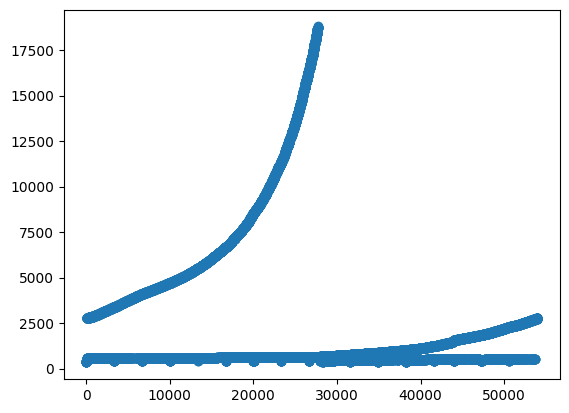

In [11]:
plt.scatter(df_train['id'], df_train['price'])

График зависимости похож на квадратичный. Попробуем это...

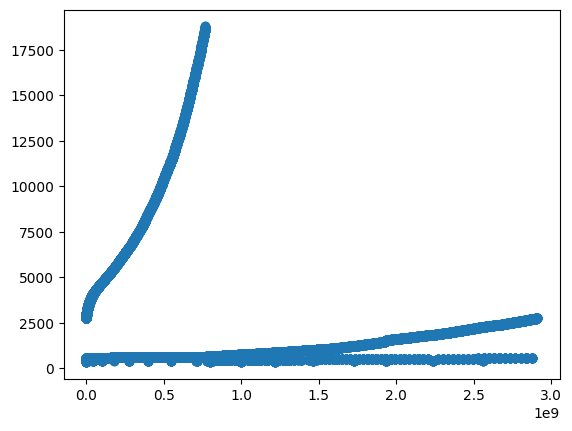

In [12]:
plt.scatter(df_train['id']**2, df_train['price'])

Зависимость уже похожа на линейную, но в ходе экспериментов было выяснено, что это ухудшает качество модели. Поэтому id останется неизменнным.

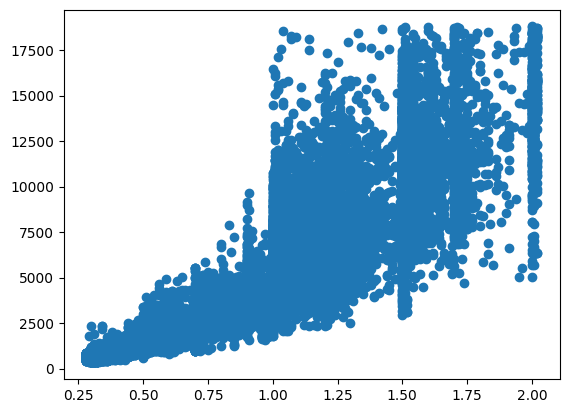

In [13]:
plt.scatter(df_train['carat'], df_train['price'])

Исходя из графика и коэффициента корреляции между каратом и таргетом, делаем вывод, что зависимость почти линейная. Карат остается неизменным.

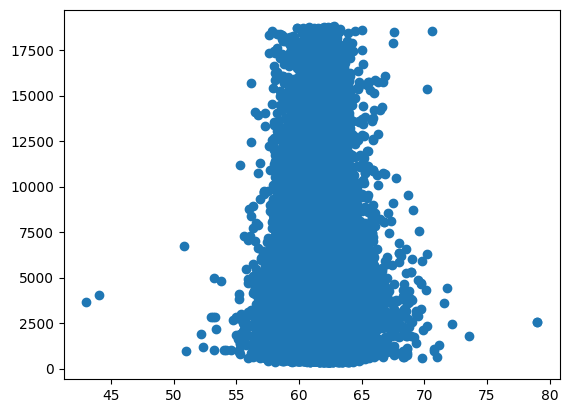

In [14]:
plt.scatter(df_train['depth'], df_train['price'])

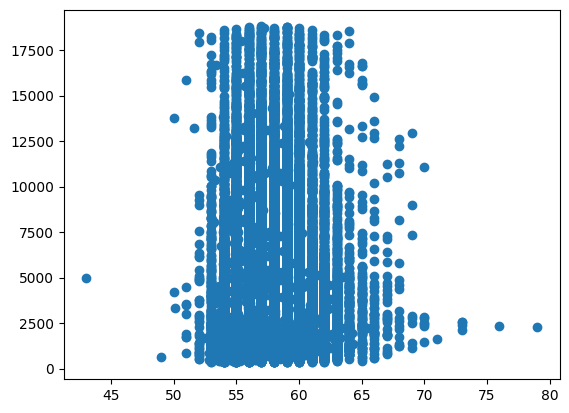

In [15]:
plt.scatter(df_train['table'], df_train['price'])

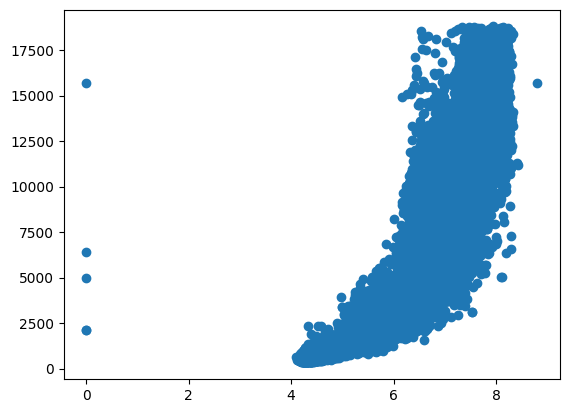

In [16]:
plt.scatter(df_train['x'], df_train['price'])

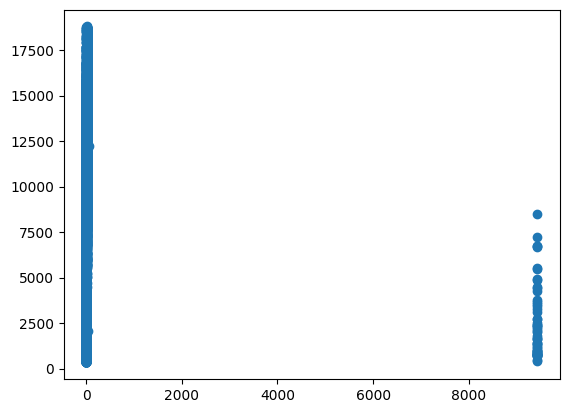

In [17]:
plt.scatter(df_train['y'], df_train['price'])

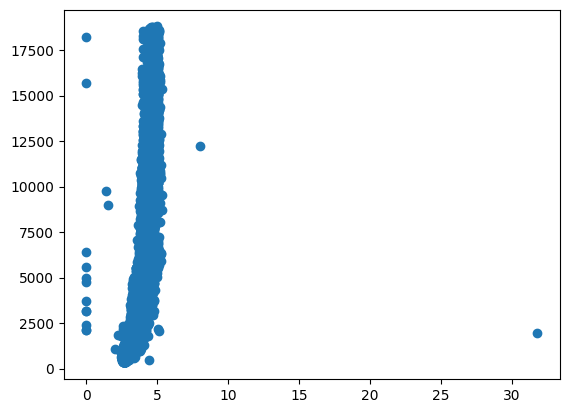

In [18]:
plt.scatter(df_train['z'], df_train['price'])

По последним пяти гррафикам видны отчетливо выбросы. То же самое было видно и на ящиках с усами. В препроцессинге избавимся от них, чтобы модель чувствовала себя лучше :)

### Preprocessing (подготовка данных)

In [19]:
# не использую
columns = ['y', "x", "z", "depth"]

for column in columns:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_train[(df_train[column] < lower_bound) | (df_train[column] > upper_bound)]

df_train = df_train[~((df_train[column] < lower_bound) | (df_train[column] > upper_bound))]

Пробовала удалять выбросы с помощью метода квантилей, как классическое определение выбросов. Но модель становилась хуже и, возможно, это приводило к ее переобучению. Поэтому удаляю выбросы у x, y, z руками. Экспериметы показали, что удаление выбросов у depth и table ухудшали качество модели на валидационной выборке.

Для начала поработаем с пропусками в данных. Эксперименты показали, что удаление пропусков дает неплохой результат, но хуже чем их заполнение.

In [ ]:
# не использую
df_train.dropna(inplace=True)

In [3]:
df_train["clarity"] = df_train["clarity"].fillna(df_train["clarity"].mode()[0])
df_train["depth"] = df_train["depth"].fillna(df_train["depth"].mean())
df_train["x"] = df_train["x"].fillna(df_train["x"].mean())
df_train["y"] = df_train["y"].fillna(df_train["y"].mean())
df_train["z"] = df_train["z"].fillna(df_train["z"].mean())

Заполнение средним значением дает лучше результат, чем заполнение медианой или модой. Причем дучше результаты, если сначала заполнять пропуски, а потом разбираться с выбросами. И если честно, мне до сих пор не ясно, почему это так, ведь среднее значение чувствительно к выбросам, и было бы логичнее сначала удалять выбросы, потом заполнять пропуски.

Добавляем объем

In [4]:
df_train["v"] = df_train["x"] * df_train["y"] * df_train['z']
df_test["v"] = df_test["x"] * df_test["y"] * df_test['z']

Объем решила считать именно таким образом, потому что он дает лучшие результаты. 

Вообще говоря существует несколько форм алмаза

Формы алмаза


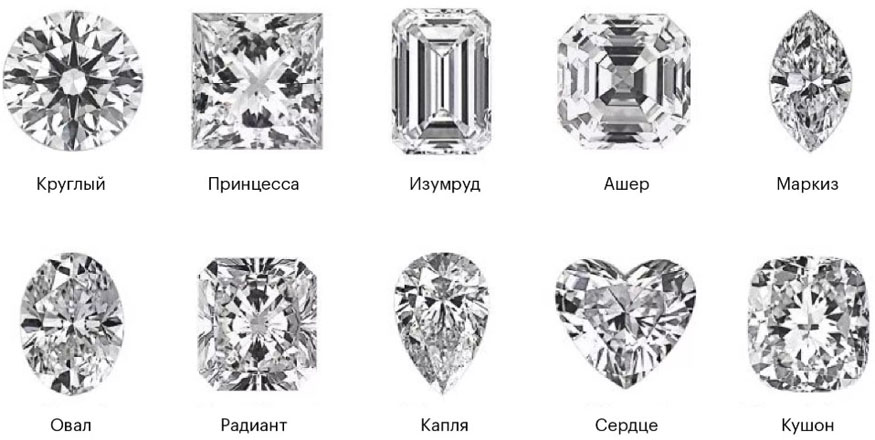

In [24]:
from IPython.display import Image
print('Формы алмаза')
Image("https://zu.ru/upload/iblock/d4d/d4d302bea3c5b6eb61b4fcd4fd03518f.jpg", width=640, height=480) 

И формулы для расчета объема для каждой формы своя. К сожаленю, я потеряла эту таблицу, поэтому ее в ноутбуке не будет. 

Самая распространенная форма алмаза - круглая. И я считала объем именно для такой формы, но это давало не очень хорошие результаты.

Также я добавляла вес алмаза разными способами. 

Сначала я умножала карат на 0.2, т.к. 1 карат = 0.2 грамм

Потом я использовала формулу для расчета веса алмаза в зависимости от формы (при предположении, что алмазы круглой формы).

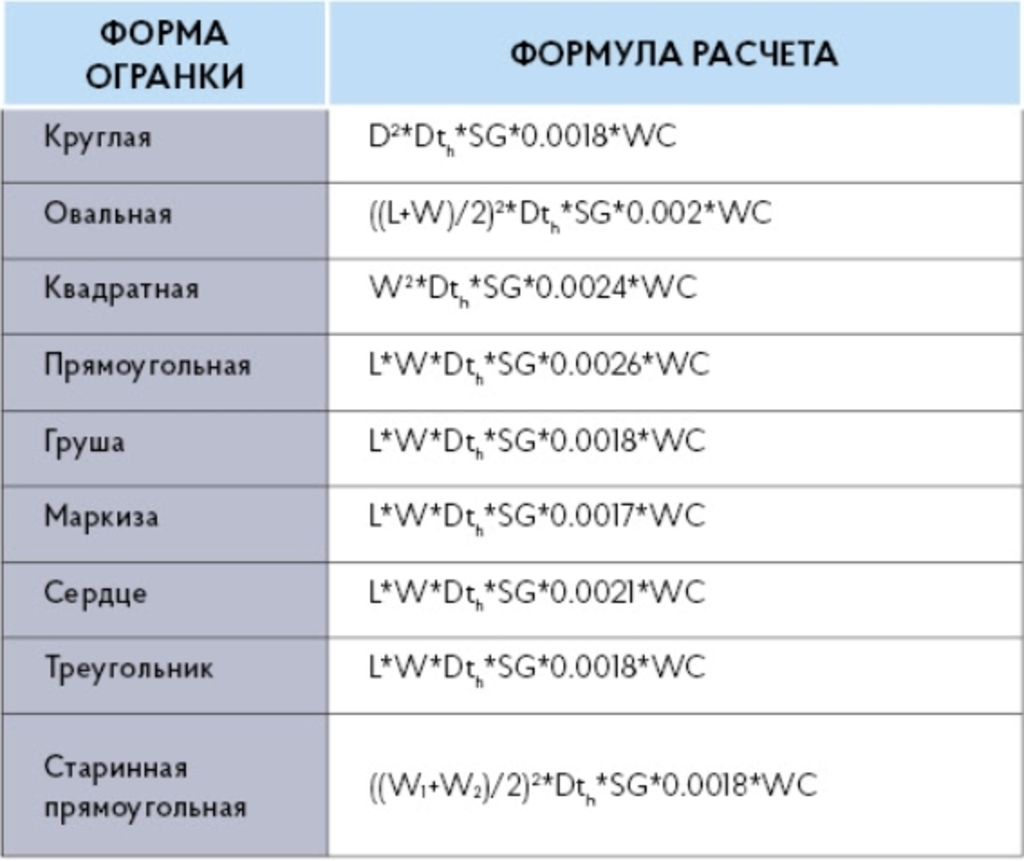

In [25]:
from IPython.display import Image

Image("https://uvelir.info/ckfinder/userfiles/images/forma_ogranki.jpg", width=640, height=480) 

В итоге в ходе экспериментов я поняла, что добавление массы и массы и объема вместе дает результаты хуже, чем добавление только объема. 

Убираем руками выбросы, чтобы модель была лучше

In [5]:
df_train = df_train[~((df_train['x'] == 0))] 
df_train = df_train[~((df_train['y'] > 8000))] 
df_train = df_train[~((df_train['z'] > 30))] 
df_train = df_train[~((df_train['z'] == 0))] 

Для категориальных признаков использую кодирования с помощью one-hot-encoding и заменой булевых масок (0, 1).
Использование булевых масок делает модель лучше.

In [6]:
df_train = pd.get_dummies(df_train, columns=['cut', 'color', 'clarity'])
df_test = pd.get_dummies(df_test, columns=['cut', 'color', 'clarity'])

bool_features_mask_train = (df_train.dtypes == "bool").values 
bool_features_mask_test = (df_test.dtypes == "bool").values

df_train.loc[:, bool_features_mask_train] = df_train.loc[:, bool_features_mask_train].astype(int)
df_test.loc[:, bool_features_mask_test] = df_test.loc[:, bool_features_mask_test].astype(int)

Также я пробовала использовать коэффициенты, чтобы закодировать порядковые признаки, чтобы модель понимала, какие признаки лучше, а какие хуже. Но это почему-то дало плохие результаты.

In [ ]:
# один из примеров
# не использую
df_train["cut_Ideal"] *= 5
df_train["cut_'Very Good'"] *= 4
df_train["cut_Good"] *= 3
df_train["cut_Premium"] *= 2
df_train["cut_Fair"] *= 1

Было решено использовать валидационную выборку для проверки качества модели. Без этого модель переобучалась.

Делю в стандартном соотношении 80/20

In [7]:
x = df_train[['id', 'carat', "x", "y", "z", "depth",  "v", "table",
        "cut_'Very Good'", 'cut_Fair', 'cut_Good', 'cut_Ideal',
       'cut_Premium', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H',
       'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2']]
y = df_train['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Model & training (Выбор модели и её обучение)

#### Эксперимент 1

Сначала я использовала обычную линейную регрессию. С ее помощью получилось преодолеть бейзлайн.

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Эксперимент 2

Чтобы исправить переобучение модели, я использовала регуляризацию. Давало не самые плохие результаты. В кегле MAE было от 350 до 600.

In [26]:
model = Ridge(alpha=0.05)
model.fit(X_train, y_train)

Ridge(alpha=0.05)

In [28]:
model = Lasso(alpha=0.05)
model.fit(X_train, y_train)

/home/user-prog/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+10, tolerance: 4.230e+07
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.05)

In [29]:
model = ElasticNet(alpha=0.05)
model.fit(X_train, y_train)

ElasticNet(alpha=0.05)

Лучше всего были результаты с L1-регуляризацией

#### Эксперимент 3

Пробовала использовать SVM для регрессии. Давало очень плохие результаты.

In [30]:
model = SVR()
model.fit(X_train, y_train)

SVR()

#### Эксперименты 4-7

Пробовала создание полиномиальных признаков для моделей в экспериментах 2-3. Результаты стали лучше

Самая лучшая степень - 3. Вторая степень давала плохие результаты, для 4 не хватает мощности

Создание полиномиальных признаков решила использовать, чтобы выявить дополнительные зависимости между признаками.

In [29]:
model = Pipeline([('poly', preprocessing.PolynomialFeatures(degree=3)), ('linear', Ridge(alpha=0.05))])
model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', Ridge(alpha=0.05))])

In [30]:
model = Pipeline([('poly', preprocessing.PolynomialFeatures(degree=3)), ('linear', Lasso(alpha=0.05))])
model.fit(X_train, y_train)

In [ ]:
model = Pipeline([('poly', preprocessing.PolynomialFeatures(degree=3)), ('linear', ElasticNet(alpha=0.05))])
model.fit(X_train, y_train)

In [ ]:
model = Pipeline([('poly', preprocessing.PolynomialFeatures(degree=3)), ('linear', SVR())])
model.fit(X_train, y_train)

#### Эксперимент 8 (лучшая модель)

In [8]:
model = Pipeline([('poly', preprocessing.PolynomialFeatures(degree=3)), ('linear', LinearRegression())])
model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression())])

### Evaluation (оценка качества модели)

In [9]:
from sklearn.metrics import mean_absolute_error

y_train_predictions = model.predict(X_train)
y_test_predictions = model.predict(X_test)


mae_train = mean_absolute_error(y_train, y_train_predictions)
mae_test = mean_absolute_error(y_test, y_test_predictions)

print("MAE train:", mae_train)
print("MAE test:", mae_test)

MAE train: 126.9821545367638
MAE test: 145.16354272386536


In [10]:
x = df_test[['id', 'carat', "x", "y", "z", "depth",  "v", "table", 
        "cut_'Very Good'", 'cut_Fair', 'cut_Good', 'cut_Ideal',
       'cut_Premium', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H',
       'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2']]

y = model.predict(x)

In [12]:
predictions_df = pd.DataFrame(data={
    'id': x["id"],
    'price': y})

predictions_df.to_csv('submission_linear4.csv', index=False)

### Conclusion (Выводы)

Помогло: построение графиков, просмотр корелляции между признаками. Манипуляция с данными с помощью one-hot encoding, просмотр боксплотов,графиков и удаление выбросов руками.

Получилось: для линейной регрессии использовать полиномиальностость для построения более сложных связей между признаками и улучшить точность модели. Конечный результат: 216.5 на кегле.

Не получилось: найти зависимость между таргетом и признаками углов. Сущает зависимость id-price. Не удалось также повысить коррелируемость table и depth с остальными признаками.

В ходе выполнения работы я пробовала использовать PCA для отбора нужных признаков, но потом поняла, что признаков на самом деле немного (не 1000), к тому же с PCA были плохие результаты.

Также были мысли по поводу того, как заполнять пропуски в данных. И была мысль, что по сути это задачи регрессии/классификации, хотелось их попробовать решить, чтобы заполнить пропуски, но я решила этого не делать, чтобы не усложнять (т.к. это по сути задача мл без учителя). 